# Environment Setup

In [1]:
# library imports

    # utils
import os
import shutil
import random
from genericpath import isdir

    # data wrangling and graphs
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colormaps

    # image handling
from PIL import Image

    # models, metrics and feature selection from sklearn

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

    # tensorflow for DL
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2        # ResNet50
from tensorflow.keras.applications import EfficientNetV2B0  # EfficientNet V2

    # keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
# GPU setup
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        print("GPU is available and set for use.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found.")

GPU is available and set for use.


# Dataset Import

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")

print("Path to dataset files:", path)

100%|██████████| 920M/920M [00:41<00:00, 23.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1


In [4]:
# paths
source = "/root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1"
destination = "/content/waste_classification"

# copy dataset
shutil.copytree(source, destination)
print(f"Dataset moved to {destination}")

Dataset moved to /content/waste_classification


In [5]:
!ls /content/waste_classification/images/images/

aerosol_cans		    glass_beverage_bottles     plastic_shopping_bags
aluminum_food_cans	    glass_cosmetic_containers  plastic_soda_bottles
aluminum_soda_cans	    glass_food_jars	       plastic_straws
cardboard_boxes		    magazines		       plastic_trash_bags
cardboard_packaging	    newspaper		       plastic_water_bottles
clothing		    office_paper	       shoes
coffee_grounds		    paper_cups		       steel_food_cans
disposable_plastic_cutlery  plastic_cup_lids	       styrofoam_cups
eggshells		    plastic_detergent_bottles  styrofoam_food_containers
food_waste		    plastic_food_containers    tea_bags


In [6]:
# define paths
source = "/content/waste_classification/images/images"
merged = "/content/waste_classification/merged"

train_path = "/content/waste_classification/train"
test_path = "/content/waste_classification/test"
validation_path = "/content/waste_classification/validation"

os.makedirs(merged, exist_ok=True)
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
os.makedirs(validation_path, exist_ok=True)

In [7]:
# merge default + real_world dirs

for category in os.listdir(source):
  category_path = os.path.join(source, category)
  if os.path.isdir(category_path):
    merged_cat_path = os.path.join(merged, category)
    os.makedirs(merged_cat_path, exist_ok=True)

    for subfolder in ["default", "real_world"]:
      subfolder_path = os.path.join(category_path, subfolder)
      if os.path.exists(subfolder_path):
        for file_name in os.listdir(subfolder_path):
          new_file_name = f"{subfolder}_{file_name}"  # new name for images
          src_file = os.path.join(subfolder_path, file_name)
          dst_file = os.path.join(merged_cat_path, new_file_name)
          shutil.copy(src_file, dst_file)

print("File copy finished")

File copy finished


### Train Test Split

In [8]:
# split into train test dirs
train_split = 0.65
test_split = 0.20
validation_split = 0.15

for category in os.listdir(merged):
  category_path = os.path.join(merged, category)

  if os.path.isdir(category_path):
    images = os.listdir(category_path)
    random.shuffle(images)

    train_index = int(len(images) * train_split)
    validation_index = train_index + int(len(images) * validation_split)

    train_images = images[:train_index]
    validation_images = images[train_index:validation_index]
    test_images = images[validation_index:]

    # make train test dir structure
    train_cat = os.path.join(train_path, category)
    test_cat = os.path.join(test_path, category)
    validation_cat = os.path.join(validation_path, category)
    os.makedirs(train_cat, exist_ok=True)
    os.makedirs(test_cat, exist_ok=True)
    os.makedirs(validation_cat, exist_ok=True)

    # copy into train test dirs
    for img in train_images:
      shutil.copy(os.path.join(category_path, img), os.path.join(train_cat, img))
    for img in test_images:
      shutil.copy(os.path.join(category_path, img), os.path.join(test_cat, img))
    for img in validation_images:
      shutil.copy(os.path.join(category_path, img), os.path.join(validation_cat, img))

print("File train test split finished")

File train test split finished


In [9]:
# check how many images in train test
def count_images(path):
  count = {}
  total = 0
  for category in os.listdir(path):
    category_path = os.path.join(path, category)
    count[category] = len(os.listdir(category_path))
    num_img = len(os.listdir(category_path))
    total += num_img
  return count, total

train_counts, train_total = count_images(train_path)
test_counts, test_total = count_images(test_path)
validation_counts, validation_total = count_images(validation_path)

print(f"Train images: {train_total}")
print(f"Test images: {test_total}")
print(f"Validation images: {validation_total}\n")

print(f"Train categories: {train_counts}")
print(f"Test categories: {test_counts}")
print(f"Validation categories: {validation_counts}\n")

Train images: 9750
Test images: 3000
Validation images: 2250

Train categories: {'plastic_cup_lids': 325, 'plastic_shopping_bags': 325, 'clothing': 325, 'paper_cups': 325, 'steel_food_cans': 325, 'office_paper': 325, 'aluminum_soda_cans': 325, 'styrofoam_food_containers': 325, 'coffee_grounds': 325, 'magazines': 325, 'plastic_food_containers': 325, 'glass_cosmetic_containers': 325, 'glass_food_jars': 325, 'plastic_trash_bags': 325, 'styrofoam_cups': 325, 'cardboard_packaging': 325, 'plastic_soda_bottles': 325, 'aluminum_food_cans': 325, 'plastic_straws': 325, 'plastic_water_bottles': 325, 'eggshells': 325, 'shoes': 325, 'food_waste': 325, 'cardboard_boxes': 325, 'disposable_plastic_cutlery': 325, 'newspaper': 325, 'tea_bags': 325, 'plastic_detergent_bottles': 325, 'aerosol_cans': 325, 'glass_beverage_bottles': 325}
Test categories: {'plastic_cup_lids': 100, 'plastic_shopping_bags': 100, 'clothing': 100, 'paper_cups': 100, 'steel_food_cans': 100, 'office_paper': 100, 'aluminum_soda_cans

# Exploratory Analysis

In [13]:
# Check image properties

# load
sample_path = '/content/waste_classification/train/food_waste/default_Image_10.png'
sample_image = Image.open(sample_path)

# properties
print(f"Size: {sample_image.size}")
print(f"Color mode: {sample_image.mode}")

Size: (256, 256)
Color mode: RGB


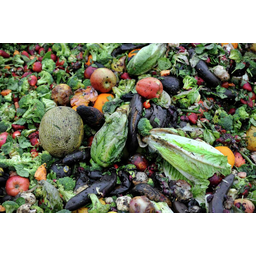

In [14]:
sample_image

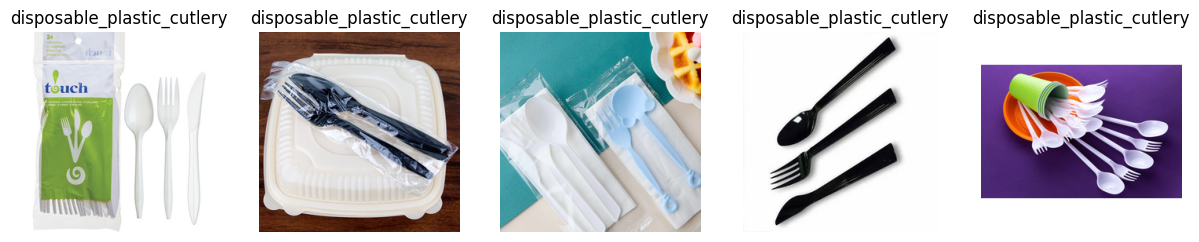

In [15]:
# visualize images
category = random.choice(os.listdir(train_path))
category_path = os.path.join(train_path, category)
sample_images = random.sample(os.listdir(category_path), 5)

plt.figure(figsize=(15, 5))
for i, img_name in enumerate(sample_images):
  img = Image.open(os.path.join(category_path, img_name))
  plt.subplot(1, 5, i+1)
  plt.imshow(img)
  plt.title(category)
  plt.axis("off")
plt.show()

# Image Preprocessing

In [53]:
# define properties
img_height, img_width = 256, 256
batch_size = 32

# data generator
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

print("Train")
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)
print("\nValidation")
validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)
print("\nTest")
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical"
)

Train
Found 9750 images belonging to 30 classes.

Validation
Found 2250 images belonging to 30 classes.

Test
Found 3000 images belonging to 30 classes.


# Models

In [54]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-7)

## ResNet 50

In [55]:
# import resnet model based on imagenet dataset and without original labels
base_model = ResNet50V2(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3),
)
base_model.trainable = False

# add custom layers for multi class problem (30 classes)
resnet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    Dense(64, activation="relu"),
    Dense(30, activation="softmax")
])

# build model
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
resnet_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 8, 8, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 30)                  │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,648,670 (94.03 MB)

 Trainable params: 1,083,870 (4.13 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [56]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

In [57]:
# train model
resnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[lr_scheduler]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


304/304 ━━━━━━━━━━━━━━━━━━━━ 157s 481ms/step - accuracy: 0.1112 - loss: 3.5066 - val_accuracy: 0.2558 - val_loss: 2.3866 - learning_rate: 0.0100
Epoch 2/20
  1/304 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.1562 - loss: 2.3761

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1562 - loss: 2.3761 - val_accuracy: 0.4000 - val_loss: 1.9540 - learning_rate: 0.0100
Epoch 3/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 143s 458ms/step - accuracy: 0.3199 - loss: 2.1541 - val_accuracy: 0.4938 - val_loss: 1.5082 - learning_rate: 0.0100
Epoch 4/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step - accuracy: 0.5312 - loss: 1.2457 - val_accuracy: 0.6000 - val_loss: 1.5773 - learning_rate: 0.0100
Epoch 5/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 144s 462ms/step - accuracy: 0.5364 - loss: 1.4581 - val_accuracy: 0.6308 - val_loss: 1.2376 - learning_rate: 0.0100
Epoch 6/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step - accuracy: 0.5938 - loss: 1.1539 - val_accuracy: 0.8000 - val_loss: 0.3977 - learning_rate: 0.0100
Epoch 7/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 144s 461ms/step - accuracy: 0.6582 - loss: 1.1559 - val_accuracy: 0.6759 - val_loss: 1.2153 - learning_rate: 0.0100
Epoch 8/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 174us/step - accuracy: 0.8125 - loss: 0.

In [58]:
# store results for comparison
results = {}

In [59]:
# evaluation
test_loss, test_accuracy = resnet_model.evaluate(test_generator)
y_true = test_generator.classes
y_pred = resnet_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.7870 - loss: 0.7562
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step
Test Loss: 0.7485864162445068
Test Accuracy: 0.7846666574478149


In [60]:
# classification report
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys(), output_dict=True)
results['ResNet50V2'] = report
print(f"ResNet50V2 Classification Report:\n{classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())}")

ResNet50V2 Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.04      0.03      0.03       100
        aluminum_food_cans       0.08      0.09      0.08       100
        aluminum_soda_cans       0.04      0.04      0.04       100
           cardboard_boxes       0.02      0.02      0.02       100
       cardboard_packaging       0.04      0.03      0.03       100
                  clothing       0.02      0.02      0.02       100
            coffee_grounds       0.07      0.07      0.07       100
disposable_plastic_cutlery       0.04      0.04      0.04       100
                 eggshells       0.01      0.01      0.01       100
                food_waste       0.02      0.02      0.02       100
    glass_beverage_bottles       0.02      0.02      0.02       100
 glass_cosmetic_containers       0.03      0.03      0.03       100
           glass_food_jars       0.04      0.04      0.04       100
             

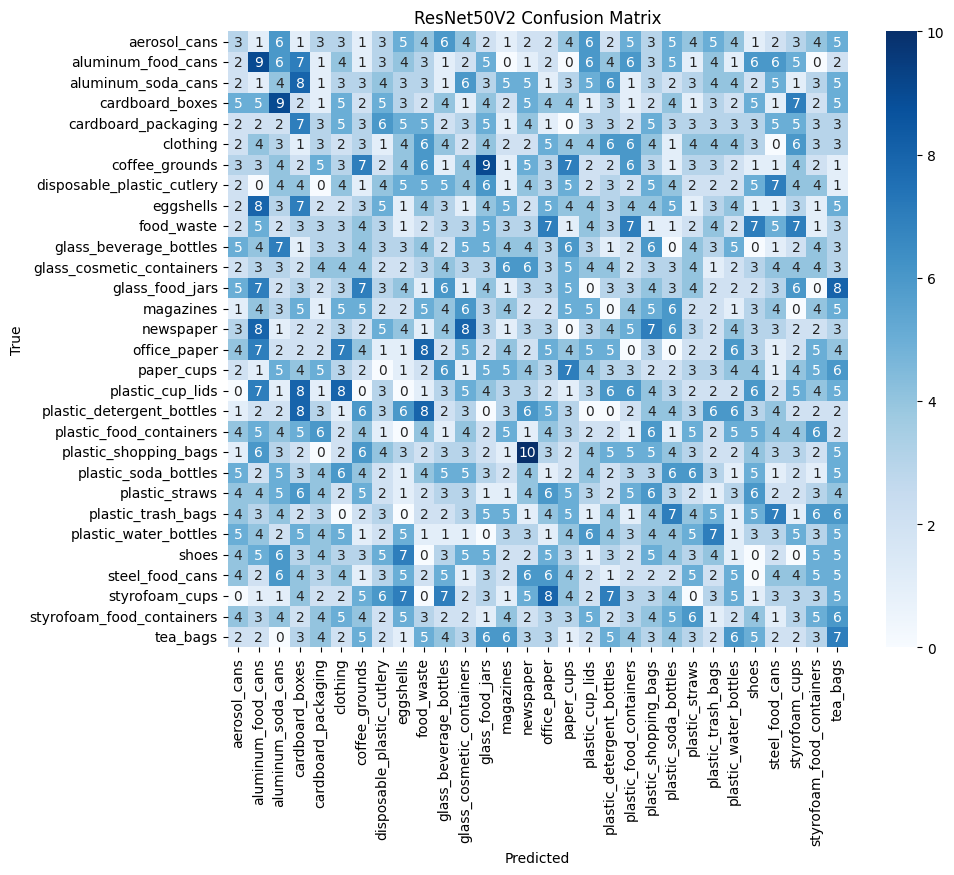

In [61]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("ResNet50V2 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## EfficientNet



In [62]:
# import efficient net model
efficientnet_base = EfficientNetV2B0(weights="imagenet", include_top=False, input_shape=(img_height, img_width, 3))
efficientnet_base.trainable = False
efficientnet_model = Sequential([
    efficientnet_base,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu"),
    Dense(30, activation="softmax")
])
efficientnet_model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
efficientnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.0320 - loss: 3.4388
Epoch 1: val_loss improved from inf to 3.40455, saving model to best_model.keras
304/304 ━━━━━━━━━━━━━━━━━━━━ 182s 510ms/step - accuracy: 0.0320 - loss: 3.4387 - val_accuracy: 0.0335 - val_loss: 3.4045 - learning_rate: 0.0010
Epoch 2/10
  1/304 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.0312 - loss: 3.4043

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 3.40455
304/304 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.0312 - loss: 3.4043 - val_accuracy: 0.0000e+00 - val_loss: 3.4313 - learning_rate: 0.0010
Epoch 3/10
303/304 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.0264 - loss: 3.4018
Epoch 3: val_loss improved from 3.40455 to 3.40121, saving model to best_model.keras
304/304 ━━━━━━━━━━━━━━━━━━━━ 141s 454ms/step - accuracy: 0.0264 - loss: 3.4018 - val_accuracy: 0.0335 - val_loss: 3.4012 - learning_rate: 0.0010
Epoch 4/10
  1/304 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.0312 - loss: 3.4018
Epoch 4: val_loss did not improve from 3.40121
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 144us/step - accuracy: 0.0312 - loss: 3.4018 - val_accuracy: 0.0000e+00 - val_loss: 3.4020 - learning_rate: 0.0010
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.0300 - loss: 3.4015
Epoch 5: val_loss did not improve from 3.40121
304/304 ━━━━━━━━━━━━━━━━━━━━ 141s 455ms/step - accuracy: 0.0300 - loss:

In [63]:
# evaluate
test_loss, test_accuracy = efficientnet_model.evaluate(test_generator)
y_true = test_generator.classes
y_pred = efficientnet_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 0.0302 - loss: 3.4013
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step
Test Loss: 3.4012012481689453, Test Accuracy: 0.03333333507180214


EfficientNet Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.00      0.00      0.00       100
        aluminum_food_cans       0.00      0.00      0.00       100
        aluminum_soda_cans       0.00      0.00      0.00       100
           cardboard_boxes       0.00      0.00      0.00       100
       cardboard_packaging       0.00      0.00      0.00       100
                  clothing       0.00      0.00      0.00       100
            coffee_grounds       0.03      1.00      0.06       100
disposable_plastic_cutlery       0.00      0.00      0.00       100
                 eggshells       0.00      0.00      0.00       100
                food_waste       0.00      0.00      0.00       100
    glass_beverage_bottles       0.00      0.00      0.00       100
 glass_cosmetic_containers       0.00      0.00      0.00       100
           glass_food_jars       0.00      0.00      0.00       100
           

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

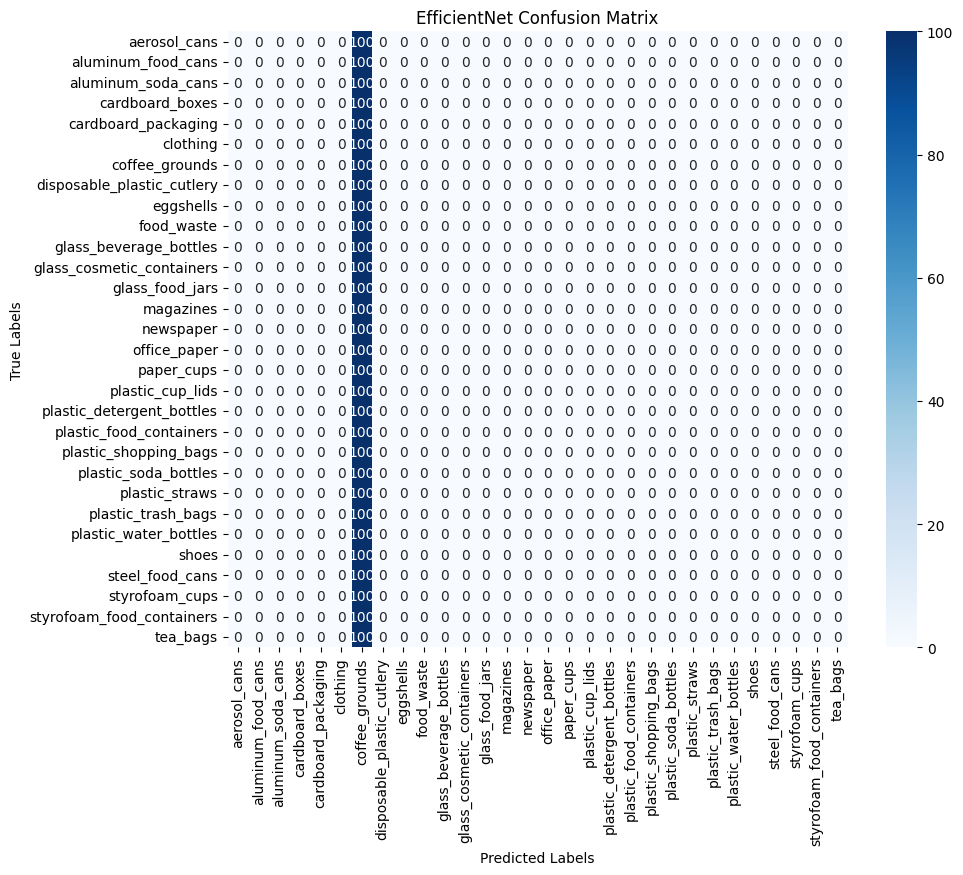

In [64]:
# Classification Report for EfficientNetV2B0
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys(), output_dict=True)
results['EfficientNetV2B0'] = report
print(f"EfficientNet Classification Report:\n{classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())}")

# Confusion Matrix for EfficientNetV2B0
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("EfficientNet Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## CNN Tensorflow

In [65]:
# cnn model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(30, activation='softmax')
])
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.0566 - loss: 23.5178
Epoch 1: val_loss did not improve from 3.39959
304/304 ━━━━━━━━━━━━━━━━━━━━ 165s 499ms/step - accuracy: 0.0566 - loss: 23.4872 - val_accuracy: 0.0362 - val_loss: 3.5083 - learning_rate: 0.0010
Epoch 2/10
  1/304 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - accuracy: 0.1250 - loss: 4.3242

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 3.39959
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1250 - loss: 4.3242 - val_accuracy: 0.0000e+00 - val_loss: 3.9992 - learning_rate: 0.0010
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.0415 - loss: 4.1853
Epoch 3: val_loss did not improve from 3.39959
304/304 ━━━━━━━━━━━━━━━━━━━━ 142s 456ms/step - accuracy: 0.0415 - loss: 4.1844 - val_accuracy: 0.0357 - val_loss: 3.4626 - learning_rate: 0.0010
Epoch 4/10
  1/304 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.0312 - loss: 3.7217
Epoch 4: val_loss improved from 3.39959 to 3.33639, saving model to best_model.keras
304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0312 - loss: 3.7217 - val_accuracy: 0.0000e+00 - val_loss: 3.3364 - learning_rate: 0.0010
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.0342 - loss: 3.4822
Epoch 5: val_loss did not improve from 3.33639
304/304 ━━━━━━━━━━━━━━━━━━━━ 142s 455ms/step - accuracy: 0.0342 - loss: 3

In [66]:
# evaluation
test_loss, test_accuracy = cnn_model.evaluate(test_generator)
y_true = test_generator.classes
y_pred = cnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.0411 - loss: 3.6017
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step
Test Loss: 3.5943291187286377, Test Accuracy: 0.04333333298563957


CNN Classification Report:
                            precision    recall  f1-score   support

              aerosol_cans       0.00      0.00      0.00       100
        aluminum_food_cans       0.00      0.00      0.00       100
        aluminum_soda_cans       0.00      0.00      0.00       100
           cardboard_boxes       0.03      0.58      0.06       100
       cardboard_packaging       1.00      0.01      0.02       100
                  clothing       0.00      0.00      0.00       100
            coffee_grounds       0.00      0.00      0.00       100
disposable_plastic_cutlery       0.00      0.00      0.00       100
                 eggshells       0.00      0.00      0.00       100
                food_waste       0.00      0.00      0.00       100
    glass_beverage_bottles       0.00      0.00      0.00       100
 glass_cosmetic_containers       0.04      0.03      0.04       100
           glass_food_jars       0.00      0.00      0.00       100
                 mag

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

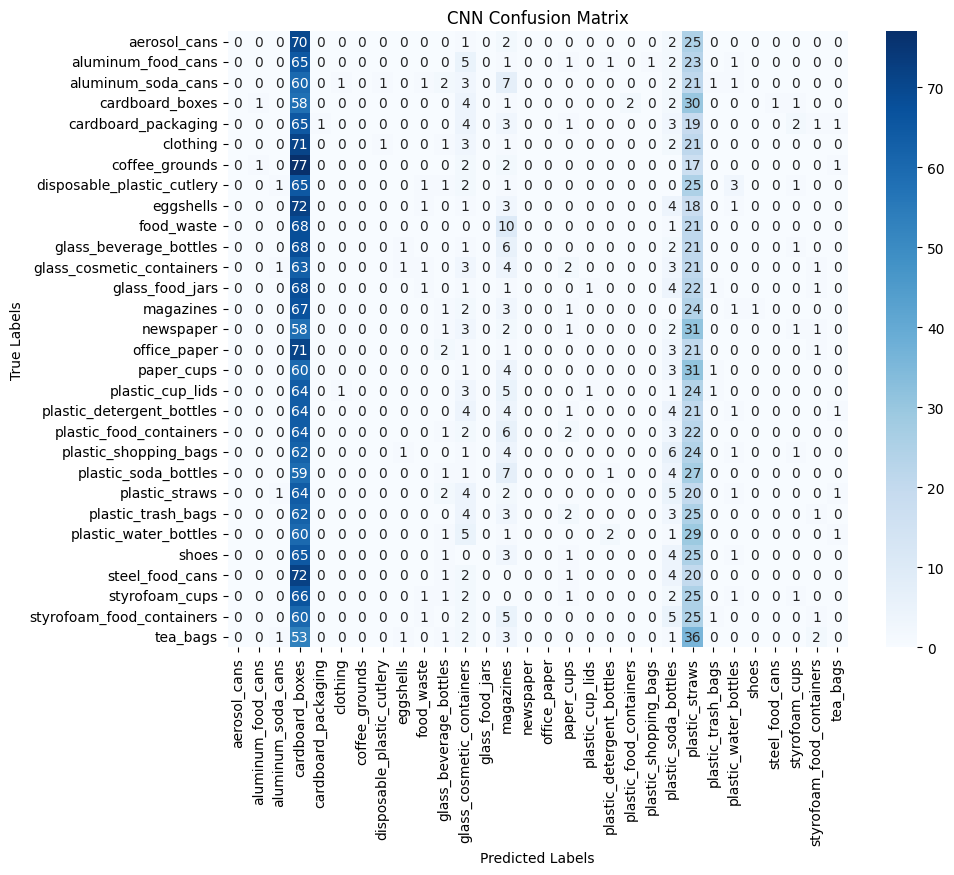

In [67]:
# Classification Report for Custom CNN
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys(), output_dict=True)
results['CNN'] = report
print(f"CNN Classification Report:\n{classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())}")

# Confusion Matrix for Custom CNN
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [68]:
# Summary of Classification Reports for Comparison
print("\nSummary of Classification Reports for All Models:\n")
for name, report in results.items():
    print(f"{name} Classification Report:")
    for key, value in report.items():
        if isinstance(value, dict):
            print(f"  {key}: Precision: {value['precision']:.2f}, Recall: {value['recall']:.2f}, F1-score: {value['f1-score']:.2f}")
        else:
            print(f"  {key}: {value:.2f}")
    print("\n")



Summary of Classification Reports for All Models:

ResNet50V2 Classification Report:
  aerosol_cans: Precision: 0.04, Recall: 0.03, F1-score: 0.03
  aluminum_food_cans: Precision: 0.08, Recall: 0.09, F1-score: 0.08
  aluminum_soda_cans: Precision: 0.04, Recall: 0.04, F1-score: 0.04
  cardboard_boxes: Precision: 0.02, Recall: 0.02, F1-score: 0.02
  cardboard_packaging: Precision: 0.04, Recall: 0.03, F1-score: 0.03
  clothing: Precision: 0.02, Recall: 0.02, F1-score: 0.02
  coffee_grounds: Precision: 0.07, Recall: 0.07, F1-score: 0.07
  disposable_plastic_cutlery: Precision: 0.04, Recall: 0.04, F1-score: 0.04
  eggshells: Precision: 0.01, Recall: 0.01, F1-score: 0.01
  food_waste: Precision: 0.02, Recall: 0.02, F1-score: 0.02
  glass_beverage_bottles: Precision: 0.02, Recall: 0.02, F1-score: 0.02
  glass_cosmetic_containers: Precision: 0.03, Recall: 0.03, F1-score: 0.03
  glass_food_jars: Precision: 0.04, Recall: 0.04, F1-score: 0.04
  magazines: Precision: 0.05, Recall: 0.04, F1-score:

In [69]:
# save models
efficientnet_model.save('efficientnetv2b0_model.h5')
resnet_model.save('resnet50v2_model.h5')
cnn_model.save('cnn_model.h5')